In [81]:
# import packages
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # import plotting module
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder # import preprocessing modules
from sklearn.compose import ColumnTransformer # import column transformer class
import sklearn.model_selection as train_test_split # import method for splitting data into training and testing sets
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, matthews_corrcoef # import metrics
from sklearn.tree import DecisionTreeClassifier # import decision tree classifier
from sklearn.ensemble import RandomForestClassifier # import random forest classifier
from sklearn.neighbors import KNeighborsClassifier # import k-nearest neighbors classifier
import torch # import pytorch
import torch.nn as nn # import pytorch for neural networks
from torch.utils.data import DataLoader, Dataset # import dataset and dataloader classes


# import modules
import classify

# check if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## 1 - Dataset

In [82]:
# read in data
data = pd.read_csv('./Data/ai4i2020.csv')
data_columns = ['UDI', 'Product ID', 'Type', 'Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
label_columns = ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']
# identify features and labels
numeric_features = ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
categorical_features = ['Type']
bin_labels = label_columns.copy()
display(data.head(3))
print('Shape of data:', data.shape)

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0


Shape of data: (10000, 14)


### Exploratory Data Analysis

#### General Statistics

In [83]:
print('Numeric Feature Columns')
feature_stats = data[numeric_features].describe().drop(['count', '25%', '50%', '75%'])
display(feature_stats)

print('Label Columns')
label_stats = data[bin_labels].describe().drop(['count', 'std', 'min', 'max', '25%', '50%', '75%']).rename(index={'mean': 'Failure Rate'})
label_stats.loc['Failure Type Proportion'] = label_stats.loc['Failure Rate'] / label_stats.loc['Failure Rate', 'Machine failure']
display(label_stats)

Numeric Feature Columns


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
mean,300.004930,310.005560,1538.776100,39.986910,107.951000
std,2.000259,1.483734,179.284096,9.968934,63.654147
min,295.300000,305.700000,1168.000000,3.800000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000


Label Columns


,Machine failure,TWF,HDF,PWF,OSF,RNF
Failure Rate,0.0339,0.004600,0.011500,0.009500,0.009800,0.001900
Failure Type Proportion,1.0000,0.135693,0.339233,0.280236,0.289086,0.056047


#### Visualizations

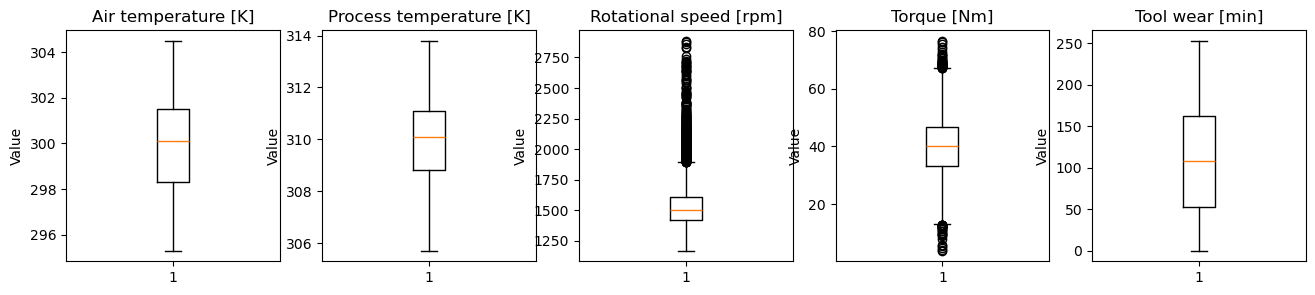

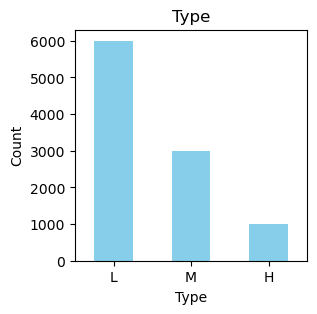

In [84]:
fig, axes = plt.subplots(1, 5, figsize=(16, 3))
for idx in range(len(numeric_features)):
    axes[idx].boxplot(data[numeric_features[idx]])
    axes[idx].set_title(numeric_features[idx])
    axes[idx].set_ylabel('Value')
plt.show()

fig, ax = plt.subplots(figsize=(3, 3))
data[categorical_features[0]].value_counts().plot(kind='bar', ax=ax, color='skyblue')
ax.set_title(categorical_features[0])
ax.set_xlabel('Type')
ax.set_ylabel('Count')
ax.tick_params(axis='x', rotation=0)
plt.show()



#### Correlations

In [85]:
print('Correlation Matrix for Features')
data[numeric_features].corr()

Correlation Matrix for Features


,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min]
Air temperature [K],1.000000,0.876107,0.022670,-0.013778,0.013853
Process temperature [K],0.876107,1.000000,0.019277,-0.014061,0.013488
Rotational speed [rpm],0.022670,0.019277,1.000000,-0.875027,0.000223
Torque [Nm],-0.013778,-0.014061,-0.875027,1.000000,-0.003093
Tool wear [min],0.013853,0.013488,0.000223,-0.003093,1.000000


### Data Restructuring
Multi-label versus multi-class classification? (problem: hardly any RNF failures)

In [86]:
def determine_failure_mode(event, specify_multiple):
    failure_modes = [failure for failure in bin_labels[1:] if event[failure] == 1]
    if not failure_modes:
        return 'No failure'
    elif specify_multiple:
        return '_'.join(failure_modes)
    else:
        return failure_modes[0] if len(failure_modes) == 1 else 'Multiple failures'

In [87]:
specify_multiple = False # what label to assign to events with multiple failures
data['Failure Mode'] = data.apply(lambda event: determine_failure_mode(event = event, specify_multiple = specify_multiple), axis=1)
categorical_labels = ['Failure Mode']
labels = bin_labels + categorical_labels
features = numeric_features + categorical_features
display(data['Failure Mode'].value_counts())

Failure Mode
No failure           9652
HDF                   106
PWF                    80
OSF                    78
TWF                    42
Multiple failures      24
RNF                    18
Name: count, dtype: int64

### Data Encoding and Normalization

In [88]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)
label_encoder = LabelEncoder()

In [89]:
X = pd.DataFrame(preprocessor.fit_transform(data[features]), columns = preprocessor.get_feature_names_out())
# y = data[labels]
# fit transform to categorical labels and combine back with numeric labels
y_categorical_encoded = pd.DataFrame(label_encoder.fit_transform(data['Failure Mode']), columns = ['Failure Mode'])
y = pd.concat([data[bin_labels], y_categorical_encoded], axis=1)

#### Final Data Format

In [90]:
display(X.head(3))
display(y.head(3))
print('Numeric features:', numeric_features)
print('Categorical features:', categorical_features)
print('Labels: ', labels)

,num__Air temperature [K],num__Process temperature [K],num__Rotational speed [rpm],num__Torque [Nm],num__Tool wear [min],cat__Type_H,cat__Type_L,cat__Type_M
0,-0.952389,-0.947360,0.068185,0.282200,-1.695984,0.0,0.0,1.0
1,-0.902393,-0.879959,-0.729472,0.633308,-1.648852,0.0,1.0,0.0
2,-0.952389,-1.014761,-0.227450,0.944290,-1.617430,0.0,1.0,0.0


,Machine failure,TWF,HDF,PWF,OSF,RNF,Failure Mode
0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,2
2,0,0,0,0,0,0,2


Numeric features: ['Air temperature [K]', 'Process temperature [K]', 'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
Categorical features: ['Type']
Labels:  ['Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF', 'Failure Mode']


### Train Test Split

In [91]:
X_remainder, X_test, y_remainder, y_test = train_test_split.train_test_split(X, y, test_size=0.1, stratify=data['Failure Mode'], random_state=42)
X_train, X_val, y_train, y_val = train_test_split.train_test_split(X_remainder, y_remainder, test_size=0.2, stratify=y_remainder['Failure Mode'], random_state=42)
print('Shape of training data:', X_train.shape)
print('Shape of validation data:', X_val.shape)
print('Shape of test data:', X_test.shape)
display(X_train.head(3), y_train.head(3))

Shape of training data: (7200, 8)
Shape of validation data: (1800, 8)
Shape of test data: (1000, 8)


,num__Air temperature [K],num__Process temperature [K],num__Rotational speed [rpm],num__Torque [Nm],num__Tool wear [min],cat__Type_H,cat__Type_L,cat__Type_M
7604,0.197519,0.872464,0.559051,-0.540397,-1.318927,0.0,1.0,0.0
4593,1.497416,0.805063,-0.723893,0.191915,-0.156337,0.0,1.0,0.0
7976,0.597488,1.613874,-0.801986,0.783783,-0.282022,1.0,0.0,0.0


,Machine failure,TWF,HDF,PWF,OSF,RNF,Failure Mode
7604,0,0,0,0,0,0,2
4593,0,0,0,0,0,0,2
7976,0,0,0,0,0,0,2


## 2 - Classifiers

### Naive Classifier
Baseline 1

In [13]:
def naive_classify(data):
    labels = [label_encoder.transform(['No failure']) for i in range(data.shape[0])]
    return labels

In [14]:
importlib.reload(classify)

naive_labels = naive_classify(X_test)
naive_accuracy = accuracy_score(naive_labels, y_test['Failure Mode'])
naive_precision = precision_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_recall = recall_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_f1 = f1_score(naive_labels, y_test['Failure Mode'], average='weighted')
naive_confusion = confusion_matrix(naive_labels, y_test['Failure Mode'])
naive_matthews = matthews_corrcoef(naive_labels, y_test['Failure Mode'])

print('Naive Classifier')
print('Accuracy:', naive_accuracy)
print('Precision:', naive_precision)
print('Recall:', naive_recall)
print('F1 Score:', naive_f1)
print('Confusion Matrix:')
print(naive_confusion)
print('Matthews Correlation Coefficient:', naive_matthews)

Naive Classifier
Accuracy: 0.965
Precision: 1.0
Recall: 0.965
F1 Score: 0.9821882951653944
Confusion Matrix:
[[  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [ 11   2 965   8   8   2   4]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Matthews Correlation Coefficient: 0.0


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Decision Tree
Baseline 2

In [15]:
importlib.reload(classify)

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train['Failure Mode'])
decision_tree_labels = decision_tree.predict(X_test)
decision_tree_accuracy = accuracy_score(decision_tree_labels, y_test['Failure Mode'])
decision_tree_precision = precision_score(decision_tree_labels, y_test['Failure Mode'], average='weighted')
decision_tree_recall = recall_score(decision_tree_labels, y_test['Failure Mode'], average='weighted')
decision_tree_f1 = f1_score(decision_tree_labels, y_test['Failure Mode'], average='weighted')
decision_tree_confusion = confusion_matrix(decision_tree_labels, y_test['Failure Mode'])
decision_tree_matthews = matthews_corrcoef(decision_tree_labels, y_test['Failure Mode'])

print('Decision Tree Classifier')
print('Accuracy:', decision_tree_accuracy)
print('Precision:', decision_tree_precision)
print('Recall:', decision_tree_recall)
print('F1 Score:', decision_tree_f1)
print('Confusion Matrix:')
print(decision_tree_confusion)
print('Matthews Correlation Coefficient:', decision_tree_matthews)

Decision Tree Classifier
Accuracy: 0.979
Precision: 0.9789834196891192
Recall: 0.979
F1 Score: 0.9785240165631469
Confusion Matrix:
[[ 11   0   0   0   0   0   0]
 [  0   1   0   0   0   0   0]
 [  0   0 957   2   4   2   2]
 [  0   1   1   5   0   0   1]
 [  0   0   0   0   4   0   0]
 [  0   0   3   0   0   0   0]
 [  0   0   4   1   0   0   1]]
Matthews Correlation Coefficient: 0.6850840182907083


In [16]:
importlib.reload(classify)

random_forest = RandomForestClassifier(random_state=42)
random_forest.fit(X_train, y_train['Failure Mode'])
random_forest_labels = random_forest.predict(X_test)
random_forest_accuracy = accuracy_score(random_forest_labels, y_test['Failure Mode'])
random_forest_precision = precision_score(random_forest_labels, y_test['Failure Mode'], average='weighted')
random_forest_recall = recall_score(random_forest_labels, y_test['Failure Mode'], average='weighted')
random_forest_f1 = f1_score(random_forest_labels, y_test['Failure Mode'], average='weighted')
random_forest_confusion = confusion_matrix(random_forest_labels, y_test['Failure Mode'])
random_forest_matthews = matthews_corrcoef(random_forest_labels, y_test['Failure Mode'])

print('Random Forest Classifier')
print('Accuracy:', random_forest_accuracy)
print('Precision:', random_forest_precision)
print('Recall:', random_forest_recall)
print('F1 Score:', random_forest_f1)
print('Confusion Matrix:')
print(random_forest_confusion)
print('Matthews Correlation Coefficient:', random_forest_matthews)

Random Forest Classifier
Accuracy: 0.985
Precision: 0.9928522020725389
Recall: 0.985
F1 Score: 0.9885893642678806
Confusion Matrix:
[[ 10   0   1   0   0   0   0]
 [  0   2   0   0   0   0   0]
 [  1   0 963   3   3   2   4]
 [  0   0   0   5   0   0   0]
 [  0   0   1   0   5   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0]]
Matthews Correlation Coefficient: 0.7549800149511631


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### k-NN

In [17]:
importlib.reload(classify)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train['Failure Mode'])
knn_labels = knn.predict(X_test)
knn_accuracy = accuracy_score(knn_labels, y_test['Failure Mode'])
knn_precision = precision_score(knn_labels, y_test['Failure Mode'], average='weighted')
knn_recall = recall_score(knn_labels, y_test['Failure Mode'], average='weighted')
knn_f1 = f1_score(knn_labels, y_test['Failure Mode'], average='weighted')
knn_confusion = confusion_matrix(knn_labels, y_test['Failure Mode'])
knn_matthews = matthews_corrcoef(knn_labels, y_test['Failure Mode'])

print('K-Nearest Neighbors Classifier')
print('Accuracy:', knn_accuracy)
print('Precision:', knn_precision)
print('Recall:', knn_recall)
print('F1 Score:', knn_f1)
print('Confusion Matrix:')
print(knn_confusion)
print('Matthews Correlation Coefficient:', knn_matthews)

K-Nearest Neighbors Classifier
Accuracy: 0.969
Precision: 0.983540956194065
Recall: 0.969
F1 Score: 0.9752398059610989
Confusion Matrix:
[[  3   0   4   0   0   0   0]
 [  0   2   0   0   0   0   0]
 [  8   0 959   6   6   2   3]
 [  0   0   0   2   0   0   0]
 [  0   0   1   0   2   0   0]
 [  0   0   0   0   0   0   0]
 [  0   0   1   0   0   0   1]]
Matthews Correlation Coefficient: 0.41457363734590097


/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Neural Network

In [96]:
class Data(Dataset):
  def __init__(self, data, targets):
    self.data = torch.tensor(data.to_numpy(), dtype=torch.float32)
    self.labels = torch.tensor(targets.to_numpy(), dtype=torch.float32)

  def __len__(self):
    return self.data.shape[0]
  
  def __getitem__(self, idx):
    return self.data[idx], self.labels[idx]

class FeedForward(nn.Module):
  def __init__(self, size_in, size_out, k):
    super(FeedForward, self).__init__()
    self.linearStack = nn.Sequential(
        nn.Linear(size_in, k),
        nn.Tanh(),
        nn.Linear(k, size_out),
    )
  
  def forward(self, x):
    x = self.linearStack(x)
    return x
  
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    tot_train_loss = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        target = target.squeeze()  # Flatten target to match output shape
        optimizer.zero_grad()
        output = model(data).squeeze()  # Flatten model output
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tot_train_loss += loss.item()
    return tot_train_loss / len(dataloader)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    targets = []
    raw_predictions = []
    total_loss = 0
    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            target = target.squeeze()  # Flatten target
            output = model(data).squeeze()  # Flatten model output
            loss = criterion(output, target)
            total_loss += loss.item()
            raw_predictions.extend(output.cpu().numpy())  # Save raw logits
            targets.extend(target.cpu().numpy())
    # Threshold raw predictions
    thresholded_predictions = np.array(raw_predictions) > 0.5
    accuracy = accuracy_score(targets, thresholded_predictions)
    avg_loss = total_loss / len(dataloader)
    return raw_predictions, thresholded_predictions, accuracy, avg_loss


[2 1 0 4 6 5 3]
[2 3 1 6 0 5 4]
[2 4 0 3 1 5 6]
Epoch 0/200 - Train Loss: 1.2568, Validation Loss: 1.2169, Validation Accuracy: 0.8906
Epoch 1/200 - Train Loss: 1.1968, Validation Loss: 1.1677, Validation Accuracy: 0.8911
Epoch 2/200 - Train Loss: 1.1459, Validation Loss: 1.1249, Validation Accuracy: 0.8922
Epoch 3/200 - Train Loss: 1.1007, Validation Loss: 1.0852, Validation Accuracy: 0.8828
Epoch 4/200 - Train Loss: 1.0610, Validation Loss: 1.0573, Validation Accuracy: 0.8917
Epoch 5/200 - Train Loss: 1.0260, Validation Loss: 1.0479, Validation Accuracy: 0.8928
Epoch 6/200 - Train Loss: 0.9950, Validation Loss: 1.0555, Validation Accuracy: 0.8944
Epoch 7/200 - Train Loss: 0.9673, Validation Loss: 0.9802, Validation Accuracy: 0.8939
Epoch 8/200 - Train Loss: 0.9423, Validation Loss: 0.9608, Validation Accuracy: 0.8961
Epoch 9/200 - Train Loss: 0.9195, Validation Loss: 0.9450, Validation Accuracy: 0.8967
Epoch 10/200 - Train Loss: 0.8989, Validation Loss: 0.9289, Validation Accuracy: 0

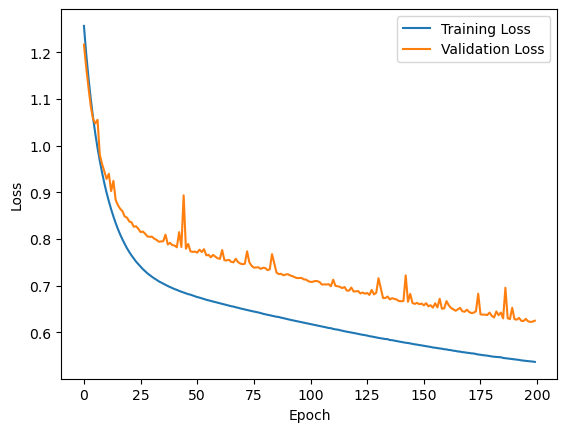

Feedforward Neural Network Classifier
Accuracy: 0.916
Precision: 0.009345794392523364
Recall: 0.030303030303030304
F1 Score: 0.014285714285714284
Confusion Matrix:
[[861 106]
 [ 32   1]]
Matthews Correlation Coefficient: -0.04583574766590439


In [97]:

# Parameters
batch_size = 32
epochs = 200
learning_rate = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_data = Data(X_train, y_train['Machine failure'])
valid_data = Data(X_val, y_val['Machine failure'])
test_data = Data(X_test, y_test['Machine failure'])

print(y_train['Failure Mode'].unique())
print(y_val['Failure Mode'].unique())
print(y_test['Failure Mode'].unique())

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

# Define Model
model = FeedForward(
    size_in=X_train.shape[1],
    size_out=1, 
    k=64
).to(device)

from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for binary labels
class_weights = compute_class_weight(
    class_weight='balanced', 
    classes=[0, 1], 
    y=y_train['Machine failure']
)
# Convert to a PyTorch tensor for use in loss function
pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32).to(device)

# Update the criterion with the pos_weight
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
training_loss = []
validation_loss = []
for epoch in range(epochs):
    avg_train_loss = train_model(model, train_loader, criterion, optimizer, device)
    raw_preds, predictions, valid_accuracy, avg_valid_loss = evaluate_model(
        model, valid_loader, criterion, device
    )
    training_loss.append(avg_train_loss)
    validation_loss.append(avg_valid_loss)

    # Ensure valid_accuracy is a scalar
    print(f"Epoch {epoch}/{epochs} - Train Loss: {avg_train_loss:.4f}, "
          f"Validation Loss: {avg_valid_loss:.4f}, Validation Accuracy: {float(valid_accuracy):.4f}")


plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on Test Data
raw_preds, test_predictions, nn_accuracy, _ = evaluate_model(model, test_loader, criterion, device)

# Calculate Metrics
nn_precision = precision_score(y_test['Machine failure'], test_predictions)
nn_recall = recall_score(y_test['Machine failure'], test_predictions)
nn_f1 = f1_score(y_test['Machine failure'], test_predictions)
nn_confusion = confusion_matrix(y_test['Machine failure'], test_predictions)
nn_matthews = matthews_corrcoef(y_test['Machine failure'], test_predictions)

print('Feedforward Neural Network Classifier')
print('Accuracy:', nn_accuracy)
print('Precision:', nn_precision)
print('Recall:', nn_recall)
print('F1 Score:', nn_f1)
print('Confusion Matrix:')
print(nn_confusion)
print('Matthews Correlation Coefficient:', nn_matthews)


## Multi_Class NN


In [98]:
class Data(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(targets.to_numpy(), dtype=torch.long)  # For multi-class, use long dtype

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class FeedForward(nn.Module):
    def __init__(self, size_in, size_out, k):
        super(FeedForward, self).__init__()
        self.linearStack = nn.Sequential(
            nn.Linear(size_in, k),
            nn.ReLU(),
            nn.Linear(k, size_out),
        )

    def forward(self, x):
        return self.linearStack(x)  # Output raw logits for CrossEntropyLoss

def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    tot_train_loss = 0
    for data, target in dataloader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)  # Raw logits
        loss = criterion(output, target)  # CrossEntropyLoss expects raw logits
        loss.backward()
        optimizer.step()
        tot_train_loss += loss.item()
    return tot_train_loss / len(dataloader)


def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)  # Raw logits
            loss = criterion(output, target)
            total_loss += loss.item()

            predictions = torch.argmax(output, dim=1)  # Get class with highest probability
            all_predictions.extend(predictions.cpu().numpy())
            all_targets.extend(target.cpu().numpy())

    accuracy = accuracy_score(all_targets, all_predictions)
    avg_loss = total_loss / len(dataloader)
    return all_predictions, accuracy, avg_loss


In [102]:
# Compute class weights for multi-class labels
batch_size = 32
epochs = 100
learning_rate = 0.0001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

unique_classes = y_train['Failure Mode'].unique()
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=unique_classes,
    y=y_train['Failure Mode']
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

# Use CrossEntropyLoss with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

train_data = Data(X_train, y_train['Failure Mode'])
valid_data = Data(X_val, y_val['Failure Mode'])
test_data = Data(X_test, y_test['Failure Mode'])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define model for multi-class classification
model = FeedForward(
    size_in=X_train.shape[1],
    size_out=len(unique_classes),  # Number of unique classes
    k=64
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

training_loss = []
validation_loss = []

for epoch in range(epochs):
    avg_train_loss = train_model(model, train_loader, criterion, optimizer, device)
    _, valid_accuracy, avg_valid_loss = evaluate_model(model, valid_loader, criterion, device)

    training_loss.append(avg_train_loss)
    validation_loss.append(avg_valid_loss)



test_predictions, nn_accuracy, _ = evaluate_model(model, test_loader, criterion, device)

nn_precision = precision_score(y_test['Failure Mode'], test_predictions,average='weighted')
nn_recall = recall_score(y_test['Failure Mode'], test_predictions,average='weighted')
nn_f1 = f1_score(y_test['Failure Mode'], test_predictions,average='weighted')
nn_confusion = confusion_matrix(y_test['Failure Mode'], test_predictions)
nn_matthews = matthews_corrcoef(y_test['Failure Mode'], test_predictions)

print('Feedforward Neural Network Classifier')
print('Accuracy:', nn_accuracy)
print('Precision:', nn_precision)
print('Recall:', nn_recall)
print('F1 Score:', nn_f1)
print('Confusion Matrix:')
print(nn_confusion)
print('Matthews Correlation Coefficient:', nn_matthews)



Epoch 1/100 - Train Loss: 1.7189, Validation Loss: 1.4621, Validation Accuracy: 0.9656
Epoch 2/100 - Train Loss: 1.2219, Validation Loss: 0.9906, Validation Accuracy: 0.9656
Epoch 3/100 - Train Loss: 0.8210, Validation Loss: 0.6584, Validation Accuracy: 0.9656
Epoch 4/100 - Train Loss: 0.5724, Validation Loss: 0.4834, Validation Accuracy: 0.9656
Epoch 5/100 - Train Loss: 0.4441, Validation Loss: 0.3966, Validation Accuracy: 0.9656
Epoch 6/100 - Train Loss: 0.3809, Validation Loss: 0.3510, Validation Accuracy: 0.9656
Epoch 7/100 - Train Loss: 0.3451, Validation Loss: 0.3331, Validation Accuracy: 0.9656
Epoch 8/100 - Train Loss: 0.3235, Validation Loss: 0.3301, Validation Accuracy: 0.9656
Epoch 9/100 - Train Loss: 0.3067, Validation Loss: 0.2989, Validation Accuracy: 0.9656
Epoch 10/100 - Train Loss: 0.2930, Validation Loss: 0.2852, Validation Accuracy: 0.9656
Epoch 11/100 - Train Loss: 0.2806, Validation Loss: 0.2875, Validation Accuracy: 0.9656
Epoch 12/100 - Train Loss: 0.2690, Valida

/opt/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 3 - Comparison

In [80]:
naive_results = {
    "Model": "naive",
    "Matthews Correlation Coefficient": naive_matthews,
    "Accuracy": naive_accuracy,
    "Precision": naive_precision,
    "Recall": naive_recall,
    "F1 Score": naive_f1
}

decision_tree_results = {
    "Model": "decision_tree",
    "Matthews Correlation Coefficient": decision_tree_matthews,
    "Accuracy": decision_tree_accuracy,
    "Precision": decision_tree_precision,
    "Recall": decision_tree_recall,
    "F1 Score": decision_tree_f1
}

knn_results = {
    "Model": "knn",
    "Matthews Correlation Coefficient": knn_matthews,
    "Accuracy": knn_accuracy,
    "Precision": knn_precision,
    "Recall": knn_recall,
    "F1 Score": knn_f1
}

random_forest_results = {
    "Model": "random_forest",
    "Matthews Correlation Coefficient": random_forest_matthews,
    "Accuracy": random_forest_accuracy,
    "Precision": random_forest_precision,
    "Recall": random_forest_recall,
    "F1 Score": random_forest_f1
}

neural_network_results = {
    "Model": "neural_network",
    "Matthews Correlation Coefficient": nn_matthews,
    "Accuracy": nn_accuracy,
    "Precision": nn_precision,
    "Recall": nn_recall,
    "F1 Score": nn_f1

}

results = [naive_results, decision_tree_results, knn_results, random_forest_results,neural_network_results]
results_df = pd.DataFrame(results)
print(results_df)
results_df.to_excel('output.xlsx', index=False)



            Model  Matthews Correlation Coefficient  Accuracy  Precision  \
0           naive                          0.000000     0.965   1.000000   
1   decision_tree                          0.685084     0.979   0.978983   
2             knn                          0.414574     0.969   0.983541   
3   random_forest                          0.754980     0.985   0.992852   
4  neural_network                          0.010416     0.917   0.038462   

     Recall  F1 Score  
0  0.965000  0.982188  
1  0.979000  0.978524  
2  0.969000  0.975240  
3  0.985000  0.988589  
4  0.121212  0.058394  
